In [53]:
import pandas as pd
import torch
from PIL import Image
from torch import optim
from torch.optim.lr_scheduler import ExponentialLR, StepLR
from torchvision import transforms
import re
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

warnings.filterwarnings("ignore", category=UserWarning)  # Disable UserWarnings
tqdm.pandas()

In [54]:
train_df = pd.read_csv("./dataset/train.csv")
test_df = pd.read_csv("./dataset/test.csv")
validation_df = pd.read_csv("./dataset/val.csv")

In [55]:
train_df

,id,caption,image_id,label
0,417812c5-0ce4-499d-b97d-4d28827239bc,Wet elephants shake water onto people bathing ...,394330,0
1,5ac91fa3-55f2-4cb3-8c8f-ad84f78e6b36,Two men holding tennis racquets on the court,130849,0
2,d2705b90-8347-4cab-a7a6-654540d9a489,A bird on a tree limb with mountains in the ba...,514790,0
3,a3b33fe7-3085-4433-9c18-8814803891b4,A kitchen and dining room are featured along w...,182096,0
4,1514b0e4-0665-45bc-ab32-52fce326cc29,A fruit stand has various fruits on the table.,68788,1
...,...,...,...,...
9995,1d1df243-485d-4b29-82c8-7e34c0de1f5c,Several people stand in a field flying a kite.,522702,0
9996,f7dfa883-e524-4974-b5ba-6b3c3db49087,A batter hitting a pitch at a baseball game.,441874,1
9997,602e83dc-6539-4c1a-8d19-c1481b5c24bf,A person on white surfboard next to group in a...,166716,0
9998,d9ce2e8c-0831-466a-8756-4c40d772b1ce,A baseball player getting ready to swing at th...,517601,0


In [56]:

# Compile the regular expression pattern
pattern = re.compile(r"[^a-z ]")


def text_preparetion(sentence):
    # 1. Lowercase everything
    sentence = sentence.lower()

    # 2. Remove all symbols other than a-z.
    sentence = re.sub(pattern, " ", sentence)

    return sentence

sentence1 = "A World War II-era bomber flying out of formation"
text_preparetion(sentence1)

'a world war ii era bomber flying out of formation'

In [57]:
train_df['preprocessed_text'] = train_df['caption'].progress_apply(text_preparetion)
validation_df['preprocessed_text'] = validation_df['caption'].progress_apply(text_preparetion)
test_df['preprocessed_text'] = test_df['caption'].progress_apply(text_preparetion)

100%|██████████| 2000/2000 [00:00<00:00, 567910.64it/s]


In [58]:
from collections import defaultdict


def build_simple_vocab(sentences, special_tokens=None):
    """
    Manually create a vocabulary from a list of tokenized sentences.
    
    Args:
        sentences (list of str): List of sentences to build vocabulary from.
        special_tokens (list of str): Special tokens like <pad>, <unk>.
        
    Returns:
        dict: A vocabulary mapping tokens to indices.
        dict: An inverse vocabulary mapping indices to tokens.
    """
    special_tokens = special_tokens or ['<pad>', '<unk>']
    vocab = defaultdict(lambda: len(vocab))  # Default index is the current vocab size
    for token in special_tokens:
        vocab[token]  # Add special tokens first
    
    # Add tokens from sentences
    for sentence in sentences:
        for token in sentence.split():
            if token.strip():  # Exclude empty tokens
                vocab[token]
    
    # Convert to a normal dict (no longer dynamic)
    vocab = dict(vocab)
    inverse_vocab = {index: token for token, index in vocab.items()}
    return vocab, inverse_vocab



# Vectorize a sentence
def vectorize_sentence(sentence, vocab):
    """
    Converts a sentence into a tensor of token indices using a given vocabulary,
    ignoring empty tokens.
    
    Args:
        sentence (str): Input sentence.
        vocab (Vocab): Vocabulary to map tokens to indices.
        
    Returns:
        torch.Tensor: Vectorized sentence as a tensor.
    """
    # Ensure '<unk>' exists in the vocabulary
    unk_idx = vocab.get('<unk>', -1)
    if unk_idx == -1:
        raise ValueError("The vocabulary must include '<unk>' for unknown tokens.")

    # Split sentence into tokens and map them to indices
    tokens = [token for token in sentence.split() if token.strip()]
    return torch.tensor([vocab.get(token, unk_idx) for token in tokens], dtype=torch.long)



# Custom Dataset Class
class PreprocessingDataset(Dataset):
    def __init__(self, dataframe, vocab, images_path, train=True, max_len=None):
        """
        Dataset for preprocessing image-text pairs.

        Args:
            dataframe (pd.DataFrame): DataFrame containing 'image_id', 'sentence', and optionally 'label'.
            vocab (Vocab): Vocabulary for text vectorization.
            train (bool): Whether this is a training dataset.
            max_len (int): Maximum length for sentences. If None, no truncation.
        """
        super().__init__()
        self.dataframe = dataframe
        self.vocab = vocab
        self.train = train
        self.max_len = max_len
        self.images_path = images_path

        # Define image transformations
        self.image_transform = transforms.Compose([
            transforms.Resize((100, 100)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]

        # Process sentence
        sentence = row['caption']
        vectorized_sentence = vectorize_sentence(sentence, self.vocab)

        # Pad or truncate the sentence
        if len(vectorized_sentence) < self.max_len:
            padding_length = self.max_len - len(vectorized_sentence)
            pad_tensor = torch.full((padding_length,), self.vocab['<pad>'], dtype=torch.long)
            vectorized_sentence = torch.cat((vectorized_sentence, pad_tensor), dim=0)
        else:
            vectorized_sentence = vectorized_sentence[:self.max_len]

        # Process image
        image_path = f"{self.images_path}{row['image_id']}.jpg"
            
        try:
            image = Image.open(image_path).convert("RGB")  # Convert to RGB
            image = self.image_transform(image)
        except FileNotFoundError:
            raise FileNotFoundError(f"Image not found at path: {image_path}")

        # Handle labels (for training)
        if self.train:
            label = row['label']
            label = torch.tensor(label, dtype=torch.long)
            return {
                'images': image,
                'captions': vectorized_sentence,
                'labels': label
            }
        else:
            return {
                'images': image,
                'captions': vectorized_sentence,
            }


In [59]:
tokenized_sentence = [sentence.split(" ") for sentence in train_df['preprocessed_text']]
max_len = max(len([token.strip() for token in sentence.split(" ")]) for sentence in train_df['preprocessed_text'])
vocab, inverse_vocab = build_simple_vocab(train_df['preprocessed_text'])

In [60]:
train_dataset = PreprocessingDataset(train_df, vocab, train=True, max_len=max_len, images_path = "./dataset/train_images/")
test_dataset = PreprocessingDataset(test_df, vocab, train=False, max_len=max_len, images_path = "./dataset/test_images/")
val_dataset = PreprocessingDataset(validation_df, vocab, train=True, max_len=max_len, images_path = "./dataset/val_images/")

In [61]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [63]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ImprovedImageTextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, lstm_hidden_dim, num_classes=1, lstm_dropout=0.3):
        super(ImprovedImageTextClassifier, self).__init__()
        
        # CNN for image feature extraction
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),  # (Batch, 32, H, W)
            nn.ReLU(),
            nn.BatchNorm2d(32),  # Normalize
            nn.Dropout(0.3),     # Dropout
            nn.MaxPool2d(kernel_size=2, stride=2),  # (Batch, 32, H/2, W/2)
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),  # (Batch, 64, H/2, W/2)
            nn.ReLU(),
            nn.BatchNorm2d(64),  # Normalize
            nn.Dropout(0.3),     # Dropout
            nn.MaxPool2d(kernel_size=2, stride=2),  # (Batch, 64, H/4, W/4)
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),  # (Batch, 128, H/4, W/4)
            nn.ReLU(),
            nn.BatchNorm2d(128),  # Normalize
            nn.Dropout(0.3),      # Dropout
            nn.AdaptiveAvgPool2d((1, 1))  # Output size (Batch, 128, 1, 1)
        )
        
        # Flatten image features to (Batch, 128)
        self.flatten = nn.Flatten()
        
        # Embedding + LSTM for text feature extraction
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=lstm_hidden_dim, batch_first=True,
                            dropout=lstm_dropout,  # Dropout between LSTM layers
                            bidirectional=False)   # Unidirectional LSTM
        
        # Regularization for LSTM (weight clipping)
        self.lstm_clipping = 1.0  # Clipping threshold for gradient values
        
        # Fully connected layers for classification
        self.fc1 = nn.Linear(128 + lstm_hidden_dim, 256)
        self.dropout_fc = nn.Dropout(0.5)  # Dropout in the fully connected layer
        self.fc2 = nn.Linear(256, num_classes)
        
    def forward(self, images, captions):
        # Image feature extraction
        img_features = self.cnn(images)  # (Batch, 128, 1, 1)
        img_features = self.flatten(img_features)  # (Batch, 128)
        
        # Text feature extraction
        embedded_captions = self.embedding(captions)  # (Batch, SeqLen, EmbeddingDim)
        lstm_out, (lstm_hidden, _) = self.lstm(embedded_captions)  # lstm_hidden: (1, Batch, HiddenDim)
        text_features = lstm_hidden.squeeze(0)  # (Batch, HiddenDim)
        
        # Combine image and text features
        combined_features = torch.cat((img_features, text_features), dim=1)  # (Batch, 128 + HiddenDim)
        
        # Classification
        x = F.relu(self.fc1(combined_features))  # (Batch, 256)
        x = self.dropout_fc(x)  # Apply dropout
        x = self.fc2(x)  # (Batch, 1 for binary classification)
        return x.squeeze(1)  # Logits (not probabilities)
    
    def clip_lstm_weights(self):
        # Clip LSTM weights to prevent exploding gradients
        for name, param in self.lstm.named_parameters():
            if "weight" in name:
                param.data = torch.clamp(param.data, -self.lstm_clipping, self.lstm_clipping)


In [64]:
# Define parameters
vocab_size = len(vocab)   # Total number of words in vocabulary
embedding_dim = 100       # Dimension of word embeddings
lstm_hidden_dim = 128     # Hidden state size for LSTM
num_classes = 1           # Binary classification (matching or non-matching)

# Initialize the model
model = ImprovedImageTextClassifier(vocab_size, embedding_dim, lstm_hidden_dim, num_classes)

In [65]:
batch = next(iter(train_dataloader))
images, captions, labels = batch['images'], batch['captions'], batch['labels']

In [66]:
output = model(images, captions)
model.to(device)
criterion = nn.BCEWithLogitsLoss()  # Use logits directly
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
num_epochs = 5

In [67]:
def training_method(model, criterion, optimizer, scheduler, num_epochs, train_loader, val_loader):
    train_losses = []  # List to store training losses
    val_losses = []  # List to store validation losses
    val_accuracies = []  # List to store validation accuracies
    val_precisions = []  # List to store validation precisions
    val_recalls = []  # List to store validation recalls
    val_f1s = []  # List to store validation F1-scores

    for epoch in range(num_epochs):

        ### TRAINING
        model.train()
        training_loss = 0.0
        
        # Add tqdm for training progress bar
        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Training")
        for batch in train_loader_tqdm:
            images = batch['images'].to(device)      # Images from batch
            captions = batch['captions'].to(device)  # Captions from batch
            labels = batch['labels'].to(device).float()  # Binary labels (0/1), converted to float
            
            optimizer.zero_grad()  # Reset gradients
            output = model(images, captions)  # Forward pass (logits)
            loss = criterion(output, labels)  # Compute loss
            loss.backward()  # Backpropagation
            
            # Clip LSTM weights
            model.clip_lstm_weights()
            
            optimizer.step()  # Update weights
            training_loss += loss.item()  # Accumulate loss
            
            # Update tqdm with current batch loss
            train_loader_tqdm.set_postfix({'Batch Loss': loss.item()})
            
        train_loss = training_loss / len(train_loader)  # Average training loss
        train_losses.append(train_loss)

        ### VALIDATING
        model.eval()
        validation_loss = 0.0
        all_labels = []  # Ground truth labels for validation
        all_preds = []   # Predictions for validation
        
        # Add tqdm for validation progress bar
        val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Validating")
        with torch.no_grad():
            for batch in val_loader_tqdm:
                images = batch['images'].to(device)
                captions = batch['captions'].to(device)
                labels = batch['labels'].to(device).float()
                
                output = model(images, captions)  # Forward pass (logits)
                loss = criterion(output, labels)  # Compute validation loss
                validation_loss += loss.item()
                
                # Convert logits to probabilities and apply threshold
                preds = (torch.sigmoid(output) > 0.5).float()
                
                # Store for statistics
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                
        val_loss = validation_loss / len(val_loader)  # Average validation loss
        val_losses.append(val_loss)
        
        # Compute validation statistics
        val_accuracy = accuracy_score(all_labels, all_preds)
        val_precision = precision_score(all_labels, all_preds, zero_division=0)
        val_recall = recall_score(all_labels, all_preds, zero_division=0)
        val_f1 = f1_score(all_labels, all_preds, zero_division=0)
        
        val_accuracies.append(val_accuracy)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1s.append(val_f1)
        
        # Step the learning rate scheduler
        scheduler.step()
        

        print(f"\nEpoch {epoch + 1}/{num_epochs} - "
              f"Training Loss: {train_loss:.4f} - "
              f"Validation Loss: {val_loss:.4f} - "
              f"Accuracy: {val_accuracy:.4f} - "
              f"Precision: {val_precision:.4f} - "
              f"Recall: {val_recall:.4f} - "
              f"F1 Score: {val_f1:.4f} - ")

    print('Training finished!')

    # Plotting the losses and validation metrics over epochs
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.plot(val_accuracies, label='Accuracy')
    plt.plot(val_precisions, label='Precision')
    plt.plot(val_recalls, label='Recall')
    plt.plot(val_f1s, label='F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('Metric')
    plt.title('Validation Metrics')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


Epoch 1/10 - Validating: 100%|██████████| 47/47 [00:02<00:00, 23.46it/s]



Epoch 1/10 - Training Loss: 0.6917 - Validation Loss: 0.6957 - Accuracy: 0.5280 - Precision: 0.5184 - Recall: 0.7880 - F1 Score: 0.6254 - Time: 10.5s



Epoch 2/10 - Validating: 100%|██████████| 47/47 [00:02<00:00, 23.19it/s]



Epoch 2/10 - Training Loss: 0.6876 - Validation Loss: 0.6902 - Accuracy: 0.5293 - Precision: 0.5205 - Recall: 0.7433 - F1 Score: 0.6123 - Time: 10.6s



Epoch 3/10 - Validating: 100%|██████████| 47/47 [00:02<00:00, 22.88it/s]



Epoch 3/10 - Training Loss: 0.6859 - Validation Loss: 0.6864 - Accuracy: 0.5410 - Precision: 0.5297 - Recall: 0.7313 - F1 Score: 0.6144 - Time: 10.6s



Epoch 4/10 - Validating: 100%|██████████| 47/47 [00:01<00:00, 23.58it/s]



Epoch 4/10 - Training Loss: 0.6845 - Validation Loss: 0.6908 - Accuracy: 0.5443 - Precision: 0.5277 - Recall: 0.8453 - F1 Score: 0.6498 - Time: 10.6s



Epoch 5/10 - Validating: 100%|██████████| 47/47 [00:01<00:00, 23.63it/s]



Epoch 5/10 - Training Loss: 0.6809 - Validation Loss: 0.6851 - Accuracy: 0.5570 - Precision: 0.5434 - Recall: 0.7133 - F1 Score: 0.6169 - Time: 10.6s



Epoch 6/10 - Validating: 100%|██████████| 47/47 [00:02<00:00, 23.34it/s]



Epoch 6/10 - Training Loss: 0.6774 - Validation Loss: 0.6875 - Accuracy: 0.5600 - Precision: 0.5466 - Recall: 0.7033 - F1 Score: 0.6152 - Time: 10.6s



Epoch 7/10 - Validating: 100%|██████████| 47/47 [00:02<00:00, 23.36it/s]



Epoch 7/10 - Training Loss: 0.6759 - Validation Loss: 0.6842 - Accuracy: 0.5627 - Precision: 0.5486 - Recall: 0.7080 - F1 Score: 0.6182 - Time: 10.6s



Epoch 8/10 - Validating: 100%|██████████| 47/47 [00:02<00:00, 23.07it/s]



Epoch 8/10 - Training Loss: 0.6752 - Validation Loss: 0.6851 - Accuracy: 0.5487 - Precision: 0.5324 - Recall: 0.7993 - F1 Score: 0.6391 - Time: 10.6s



Epoch 9/10 - Validating: 100%|██████████| 47/47 [00:02<00:00, 23.07it/s]



Epoch 9/10 - Training Loss: 0.6736 - Validation Loss: 0.6865 - Accuracy: 0.5487 - Precision: 0.5330 - Recall: 0.7853 - F1 Score: 0.6350 - Time: 10.7s



Epoch 10/10 - Validating: 100%|██████████| 47/47 [00:02<00:00, 23.31it/s]



Epoch 10/10 - Training Loss: 0.6717 - Validation Loss: 0.6856 - Accuracy: 0.5533 - Precision: 0.5397 - Recall: 0.7253 - F1 Score: 0.6189 - Time: 10.7s

Training finished!


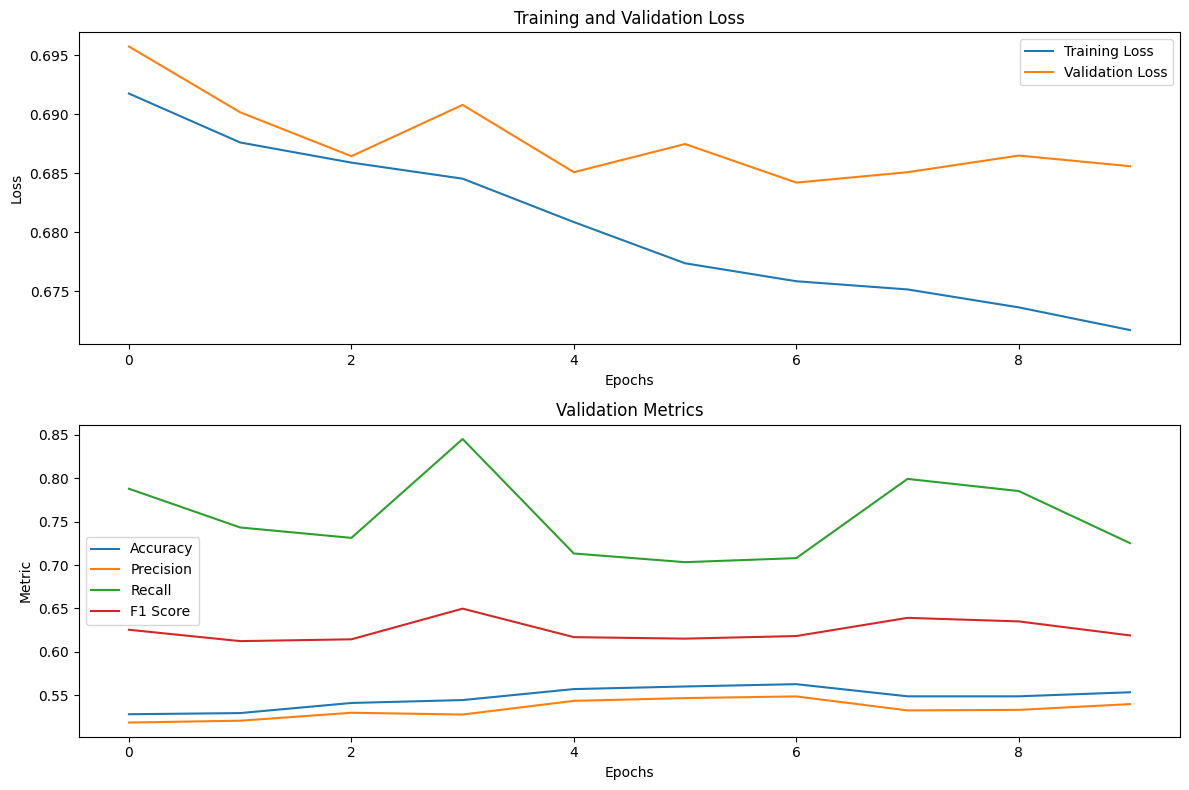

In [68]:
training_method(model, criterion, optimizer, scheduler, num_epochs=10, train_loader=train_dataloader, val_loader=val_dataloader)